# EDA of Customer Churn Telco Data
## Author: Hristo Panov

## 00 Prerequisite and packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Custom Imports
import sys
sys.path.insert(0, '..')

from utils.const_folders import folder_paths
from utils.function_freqs import freqs

%matplotlib inline

## 01 Read Data

In [2]:
# Read From CSV
df = pd.read_csv(
    f"{folder_paths.path}/WA_Fn-UseC_-Telco-Customer-Churn.csv"
    ,sep=","
    ,index_col=None
)

## 02 Data Audit

In [3]:
# Columns and Rows
print('The dataset contains {one} rows and {two} columns'.format(one=df.shape[0],two=df.shape[1]))
print('Those columns are {one}'.format(one=df.columns.to_list()))

The dataset contains 7043 rows and 21 columns
Those columns are ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [4]:
# Preview
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
219,6496-JDSSB,Female,0,No,No,8,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),80.00,624.6,No
2711,0431-APWVY,Female,0,Yes,Yes,28,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,One year,Yes,Bank transfer (automatic),90.10,2598.95,Yes
3436,0428-AXXLJ,Male,0,No,No,25,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),19.50,516.3,No
6188,7542-CYDDM,Male,0,No,No,18,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.05,358.5,No
1970,5445-UTODQ,Female,0,Yes,No,7,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,81.10,576.65,Yes


In [5]:
#Check if the dataframe is unique on Customer Level - aka each row cointains information about one customer
df.shape[0] == len(df['customerID'].unique())

True

In [6]:
#Set the index of the data set to be equal to the customerID
df.set_index('customerID',inplace=True)

In [7]:
#Explore Feature types
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## 03 Data Prep

#### MonthlyCharges

In [8]:
# Total Charges are expected to be numeric. Lets Convert them
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
# Check if the conversion is sucesfull
print('The datatype of {one} is {two}'.format(one="TotalCharges",two=df["TotalCharges"].dtypes ))

The datatype of TotalCharges is float64


In [9]:
# Check For Missing Values
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

TotalCharges has the following descripton :
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

The number of missing observations is 11.
The average value is 2283.3.
The median value is 1397.47.


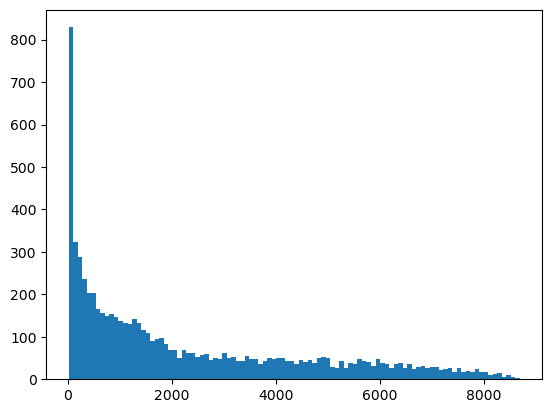

In [10]:
# It Appaers that we have some mising values for Total Charges. Lets explore it
# Describe it
print("{one} has the following descripton :\n{two}".format(one="TotalCharges", two = df['TotalCharges'].describe().T, sep='\n'))

print("\nThe number of missing observations is {}.".format(sum(df['TotalCharges'].isnull())),
      "The average value is {}.".format(round(df.TotalCharges.mean(),2)),
      "The median value is {}.".format(round(df.TotalCharges.median(),2)), sep='\n')

# Plot a Hist
plt.hist(df['TotalCharges'],bins=100,color ="tab:blue")
plt.show()



In [11]:
# Lets Fill the NA records for monthly Charges with the median value
df['TotalCharges'].fillna(df['TotalCharges'].median() ,inplace = True)
# Lets Check if we have 0 records
df['TotalCharges'].isna().sum()

0

In [12]:
#Lets Explore the Other Numerical Features
df.describe().round().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
tenure,7043.0,32.0,25.0,0.0,9.0,29.0,55.0,72.0
MonthlyCharges,7043.0,65.0,30.0,18.0,36.0,70.0,90.0,119.0
TotalCharges,7043.0,2282.0,2265.0,19.0,402.0,1397.0,3787.0,8685.0


In [13]:
df['SeniorCitizen'].value_counts()

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

#### SeniorCitizen

In [14]:
# The SeniorCitizen seems like a categorical variable and a flag - yes/no.Change the dtype to object and replace values
#Replace
df['SeniorCitizen'] = np.where(df["SeniorCitizen"] == 0, "No", "Yes")
#Convert
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
#Check
df['SeniorCitizen'].value_counts()


SeniorCitizen
No     5901
Yes    1142
Name: count, dtype: int64

## 04 EDA

### 04.1 Categorical Variables

In [15]:
# Create list of Categorical Variables:
categorical_var_list = list(df.select_dtypes(include = "object"))
print(categorical_var_list)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


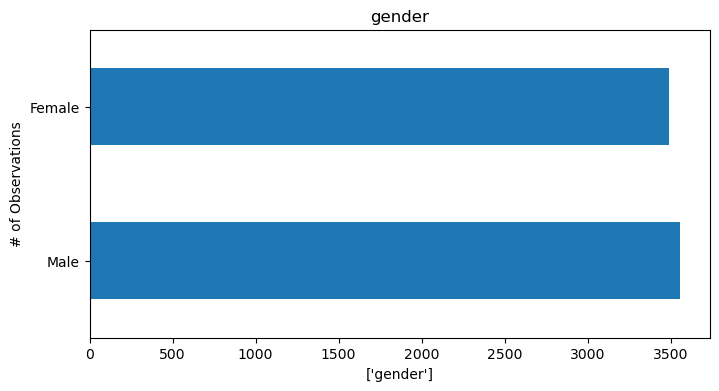

Cross Table gender 
        N_Obs  % from Total
gender                     
Male     3555         50.48
Female   3488         49.52


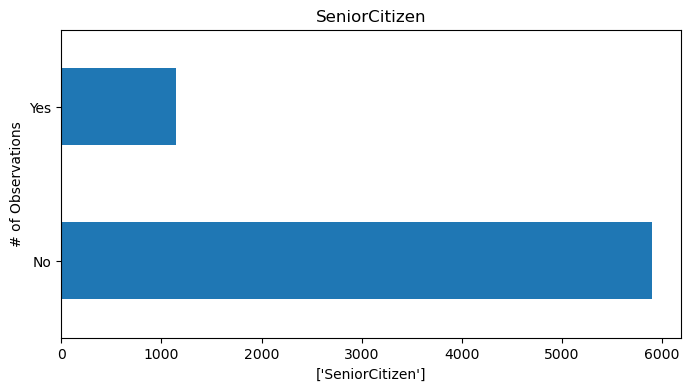

Cross Table SeniorCitizen 
               N_Obs  % from Total
SeniorCitizen                     
No              5901         83.79
Yes             1142         16.21


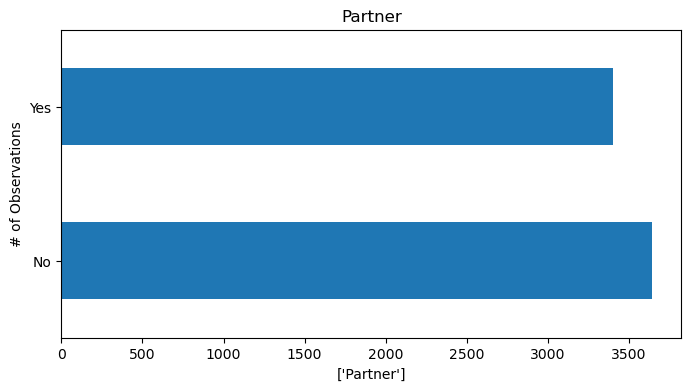

Cross Table Partner 
         N_Obs  % from Total
Partner                     
No        3641          51.7
Yes       3402          48.3


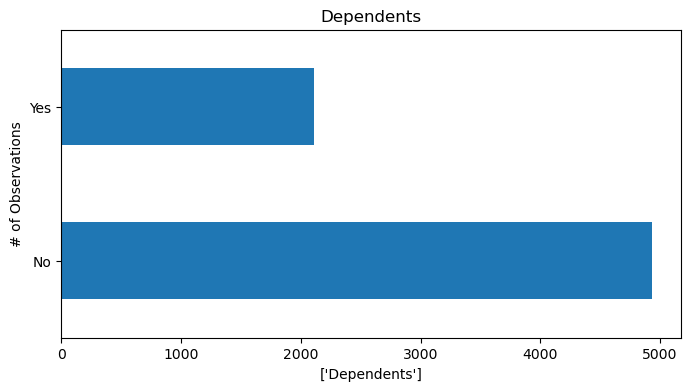

Cross Table Dependents 
            N_Obs  % from Total
Dependents                     
No           4933         70.04
Yes          2110         29.96


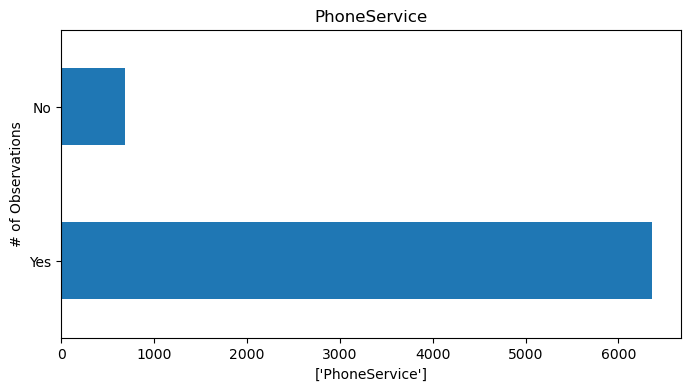

Cross Table PhoneService 
              N_Obs  % from Total
PhoneService                     
Yes            6361         90.32
No              682          9.68


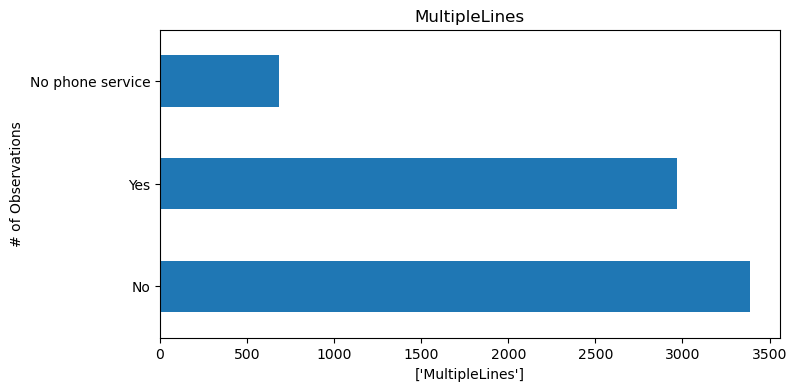

Cross Table MultipleLines 
                  N_Obs  % from Total
MultipleLines                        
No                 3390         48.13
Yes                2971         42.18
No phone service    682          9.68


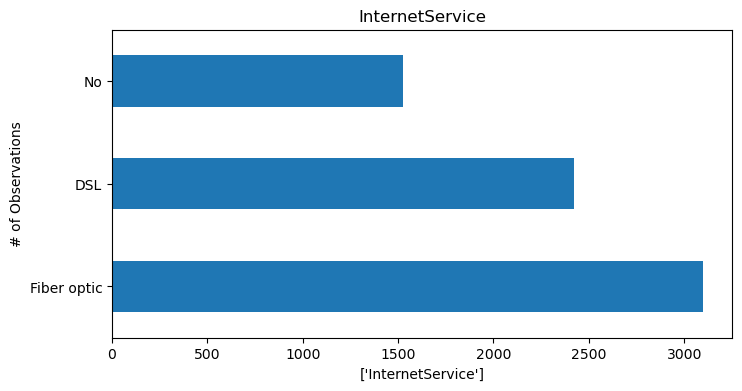

Cross Table InternetService 
                 N_Obs  % from Total
InternetService                     
Fiber optic       3096         43.96
DSL               2421         34.37
No                1526         21.67


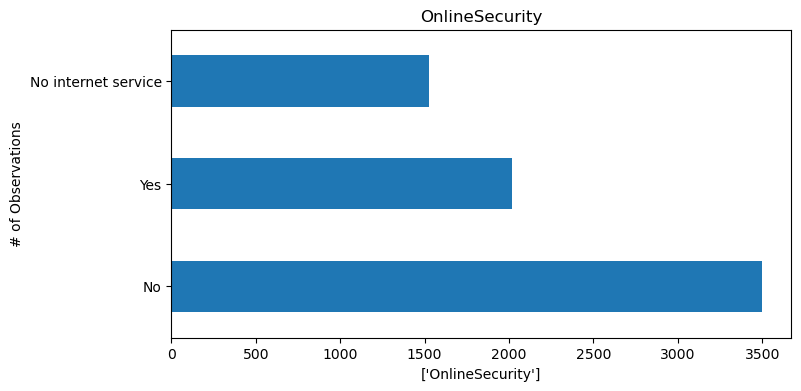

Cross Table OnlineSecurity 
                     N_Obs  % from Total
OnlineSecurity                          
No                    3498         49.67
Yes                   2019         28.67
No internet service   1526         21.67


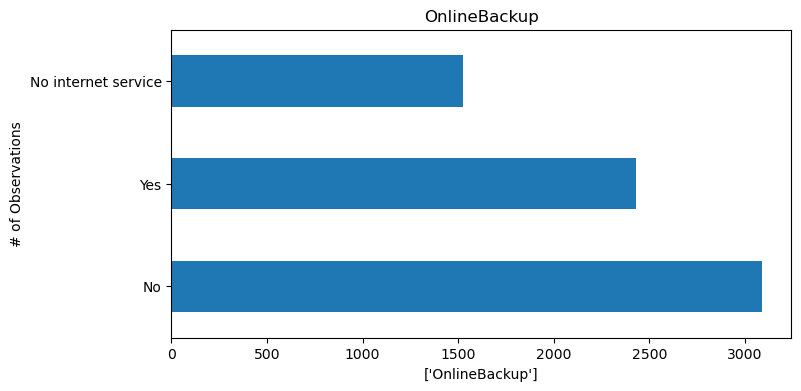

Cross Table OnlineBackup 
                     N_Obs  % from Total
OnlineBackup                            
No                    3088         43.84
Yes                   2429         34.49
No internet service   1526         21.67


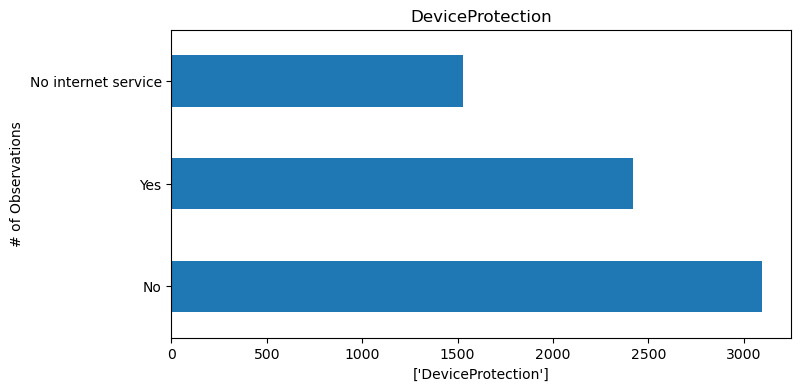

Cross Table DeviceProtection 
                     N_Obs  % from Total
DeviceProtection                        
No                    3095         43.94
Yes                   2422         34.39
No internet service   1526         21.67


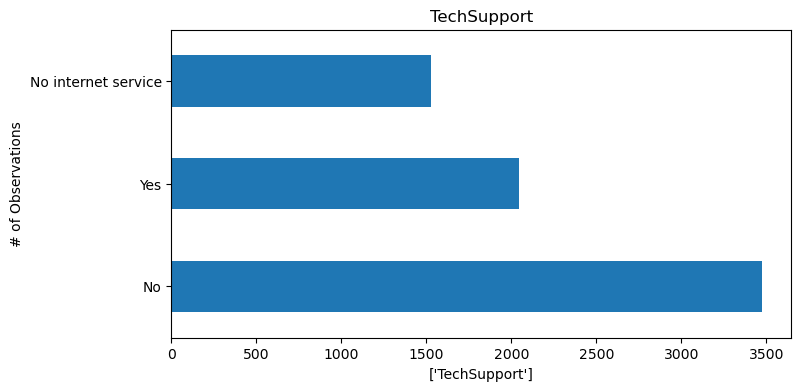

Cross Table TechSupport 
                     N_Obs  % from Total
TechSupport                             
No                    3473         49.31
Yes                   2044         29.02
No internet service   1526         21.67


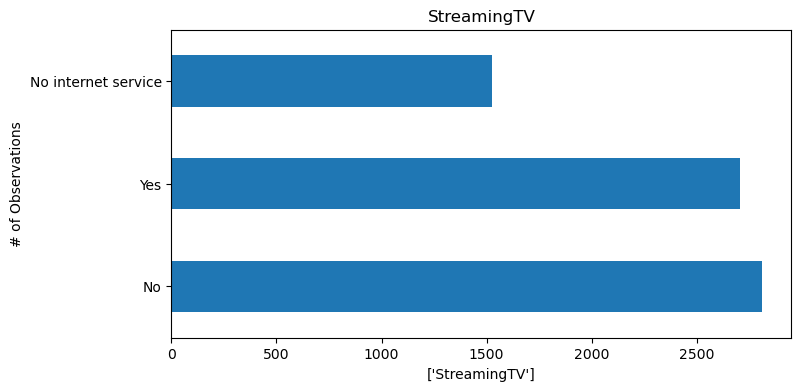

Cross Table StreamingTV 
                     N_Obs  % from Total
StreamingTV                             
No                    2810         39.90
Yes                   2707         38.44
No internet service   1526         21.67


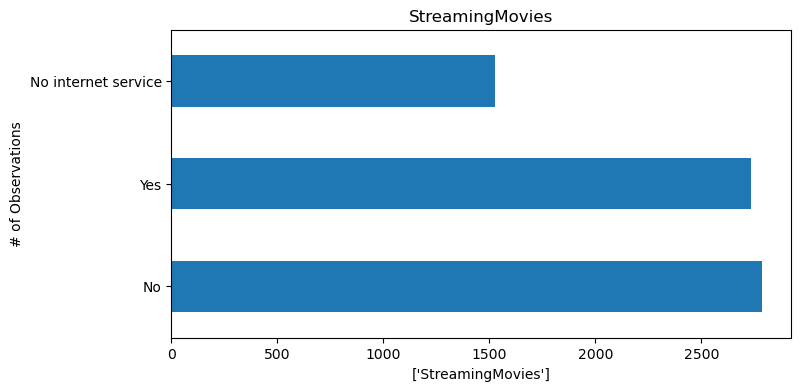

Cross Table StreamingMovies 
                     N_Obs  % from Total
StreamingMovies                         
No                    2785         39.54
Yes                   2732         38.79
No internet service   1526         21.67


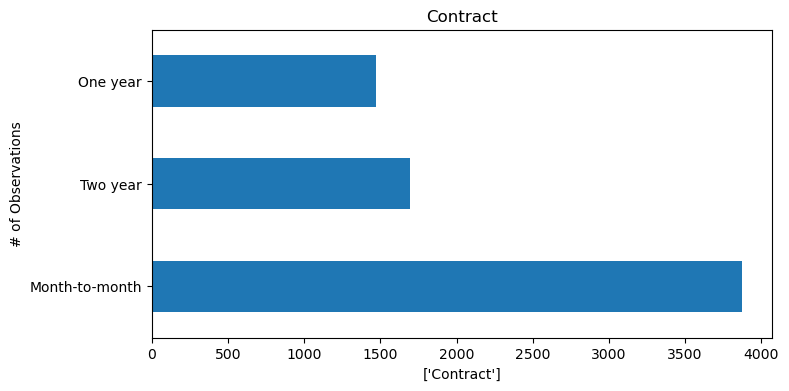

Cross Table Contract 
                N_Obs  % from Total
Contract                           
Month-to-month   3875         55.02
Two year         1695         24.07
One year         1473         20.91


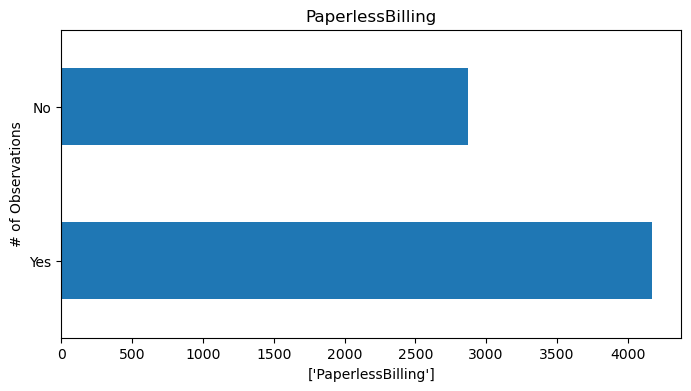

Cross Table PaperlessBilling 
                  N_Obs  % from Total
PaperlessBilling                     
Yes                4171         59.22
No                 2872         40.78


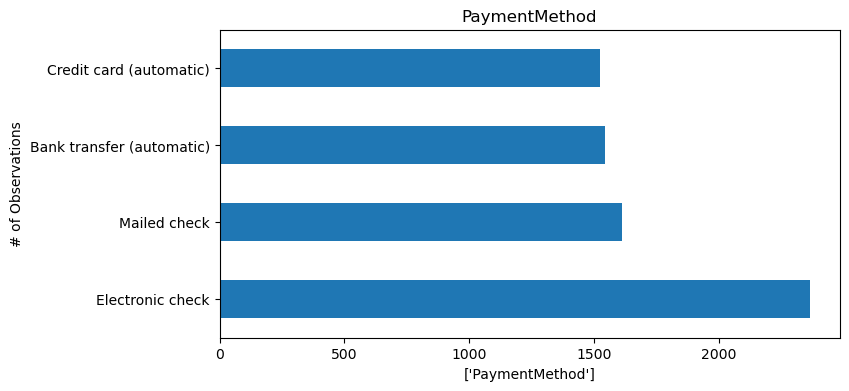

Cross Table PaymentMethod 
                           N_Obs  % from Total
PaymentMethod                                 
Electronic check            2365         33.58
Mailed check                1612         22.89
Bank transfer (automatic)   1544         21.92
Credit card (automatic)     1522         21.61


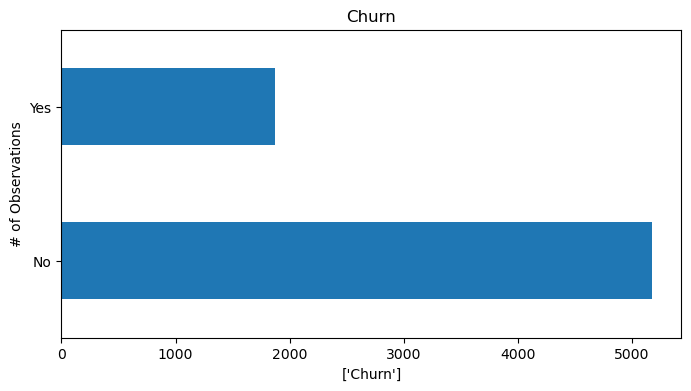

Cross Table Churn 
       N_Obs  % from Total
Churn                     
No      5174         73.46
Yes     1869         26.54


In [16]:
for var in categorical_var_list:
    freqs.feature_graph_freq(df,var,'barh')

### 04.2 Numerical Variables

In [17]:
# Create list of Categorical Variables:
numerical_var_list = list(df.select_dtypes(include = ['float64','int64']))
print(numerical_var_list)

['tenure', 'MonthlyCharges', 'TotalCharges']


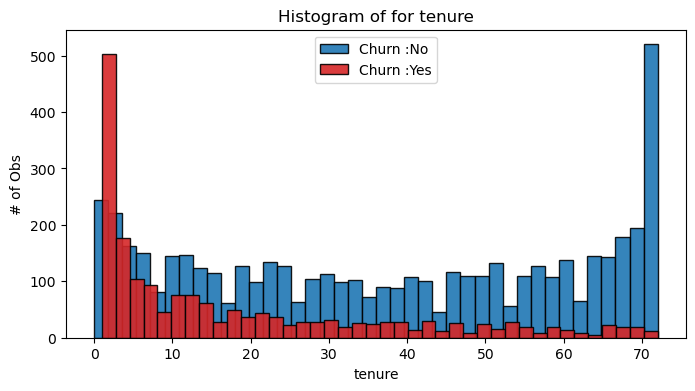

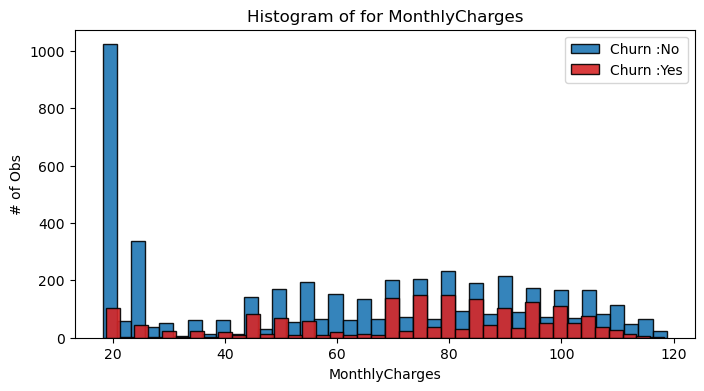

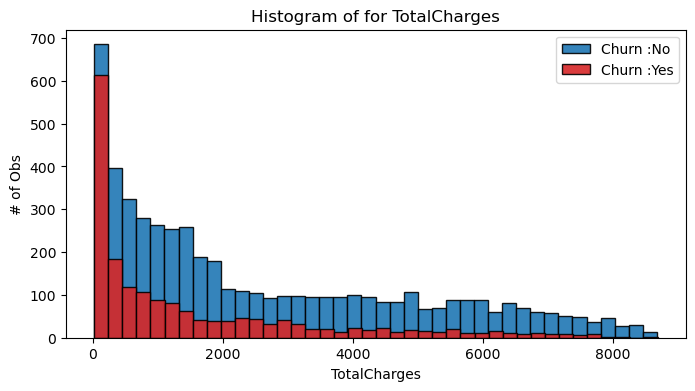

In [18]:
#Plot it
for var in numerical_var_list:
    freqs.plot_hist_two_ax(df,var,'Churn',40)

### 04.3 Numeric variables against dependant

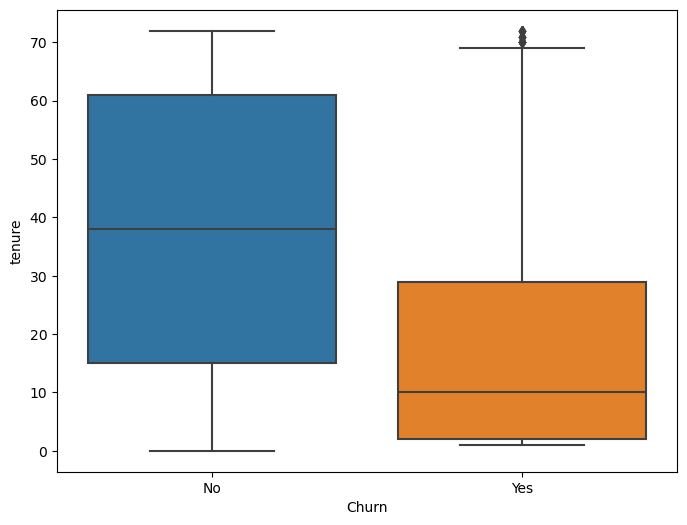

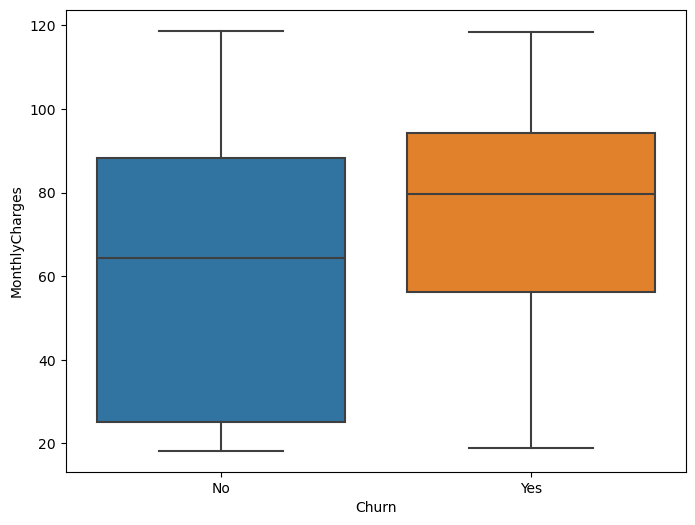

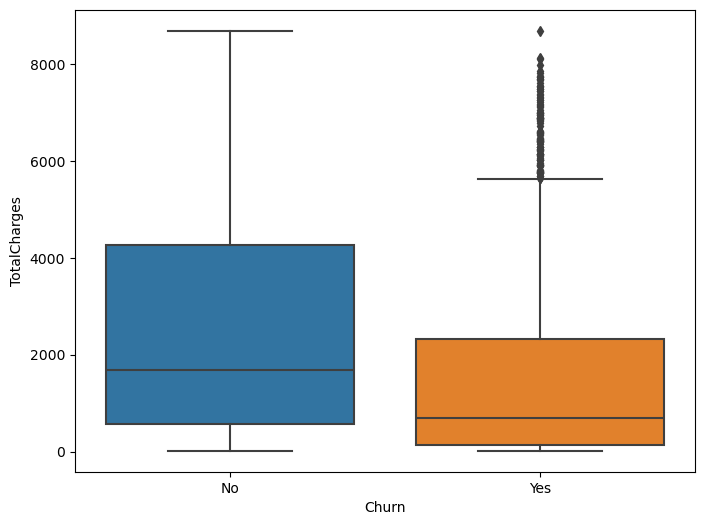

In [19]:
# Explore Numerical Variables Against Dependant
for vars in numerical_var_list:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Churn',y=vars,data=df,palette='tab10')
    plt.show()

### 04.4 Categorical variables against dependant

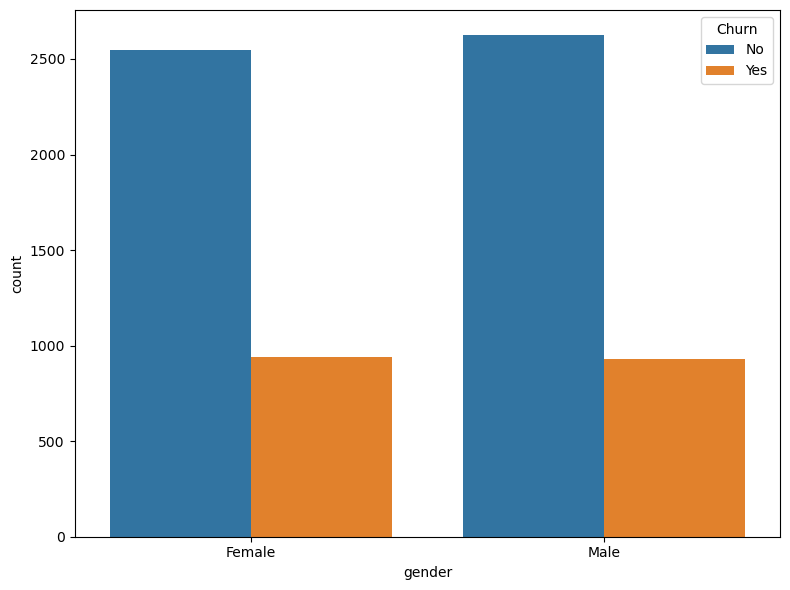

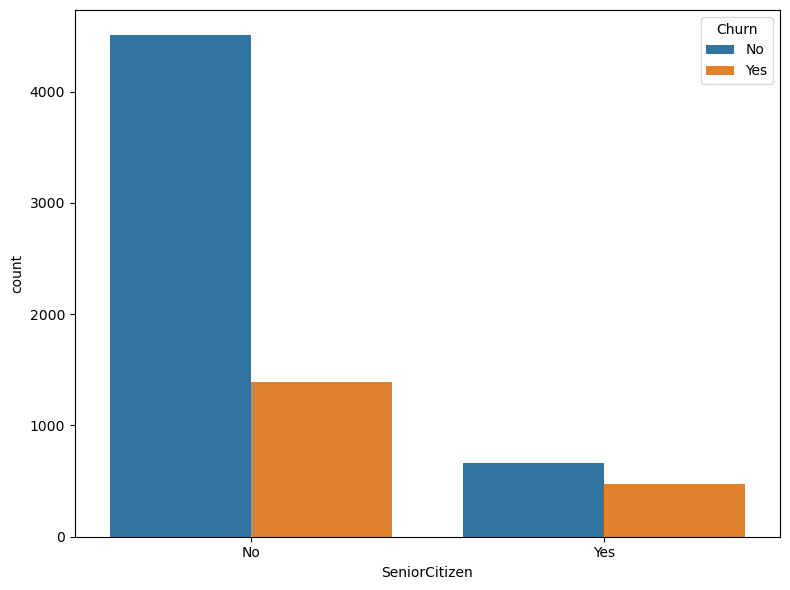

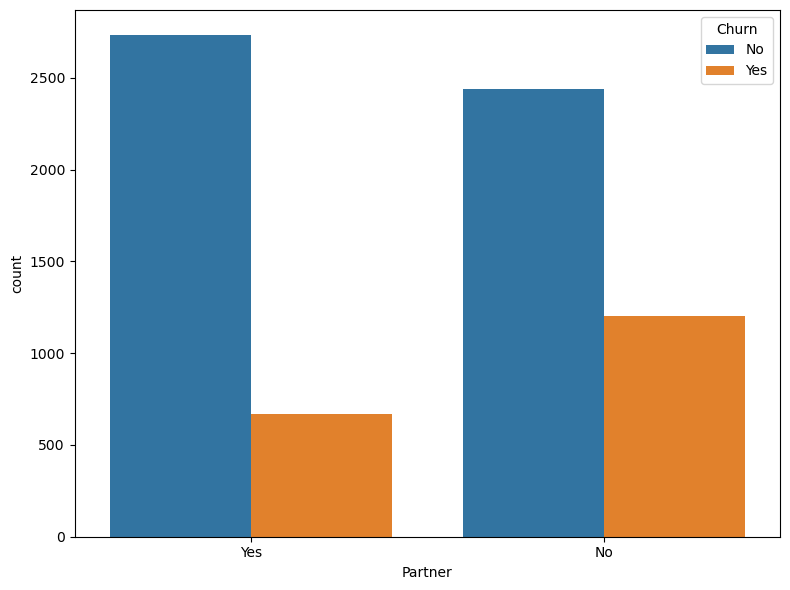

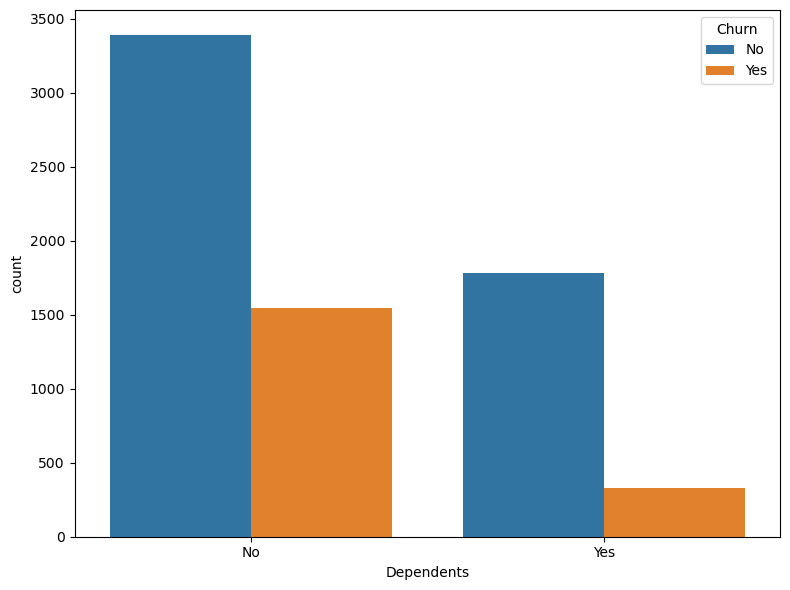

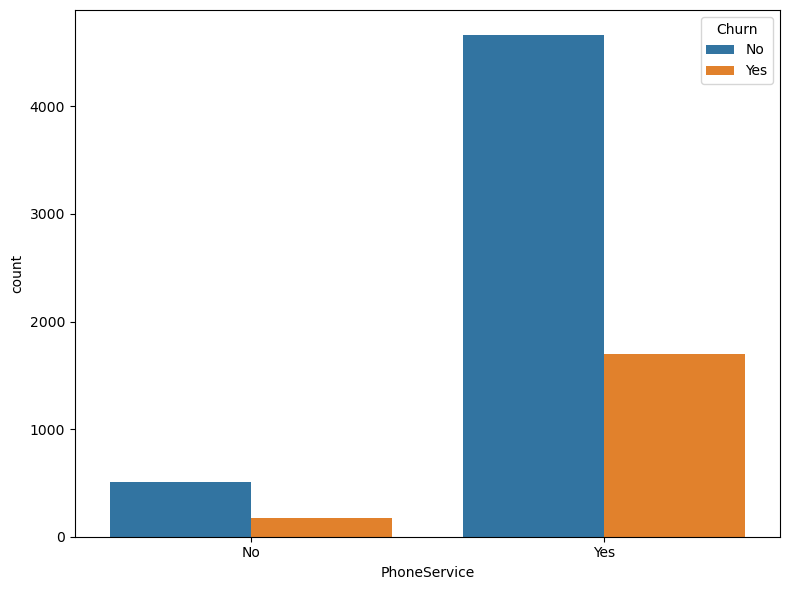

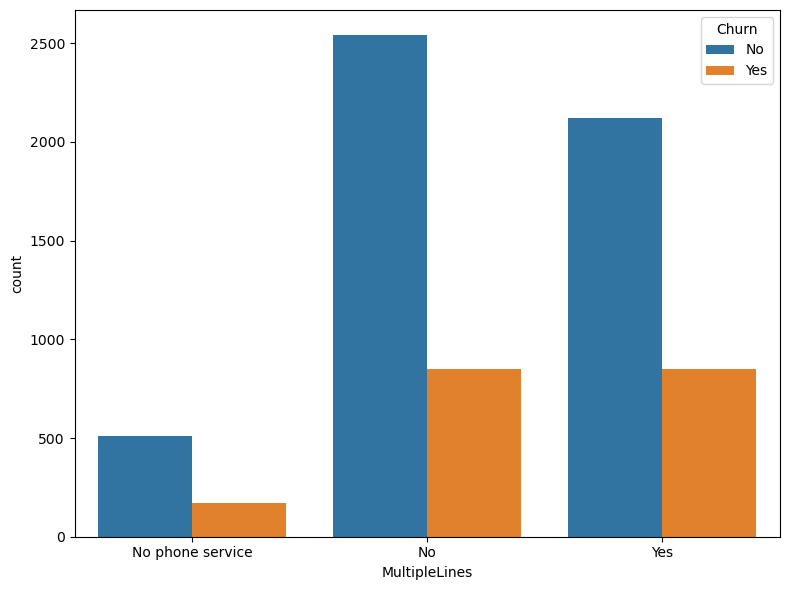

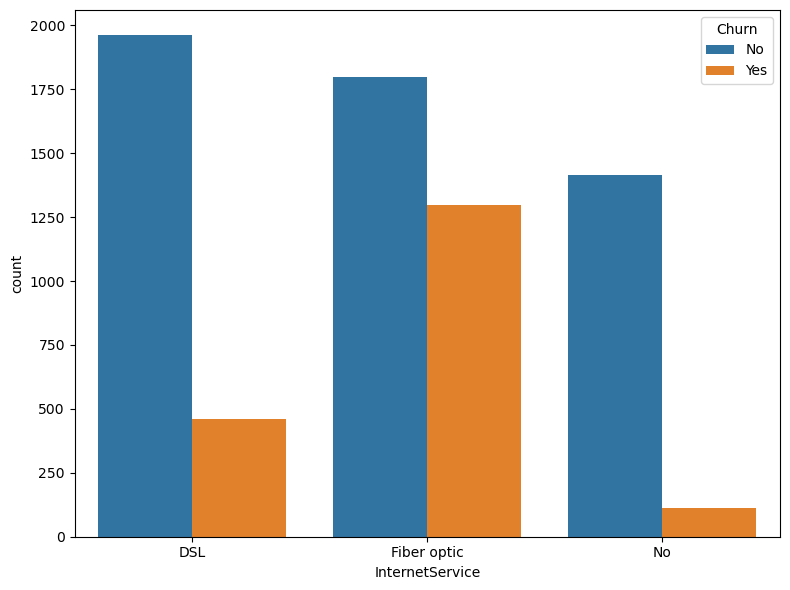

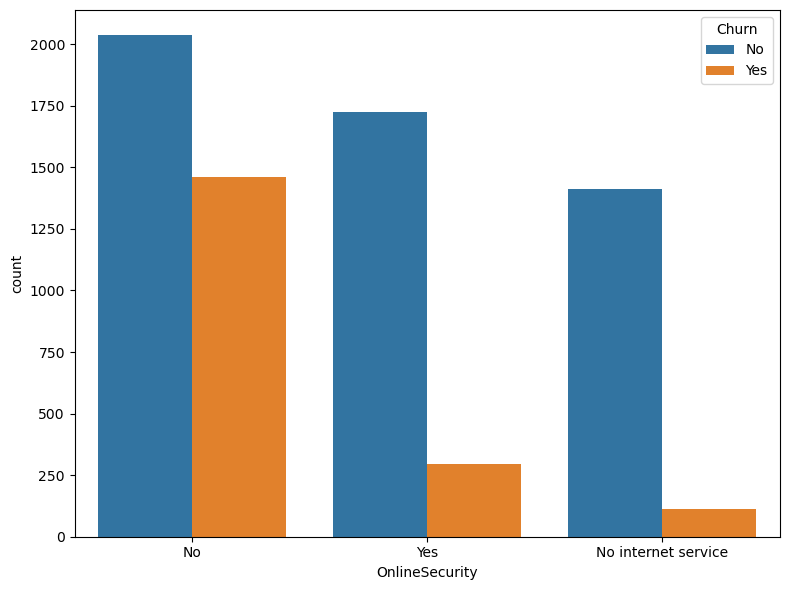

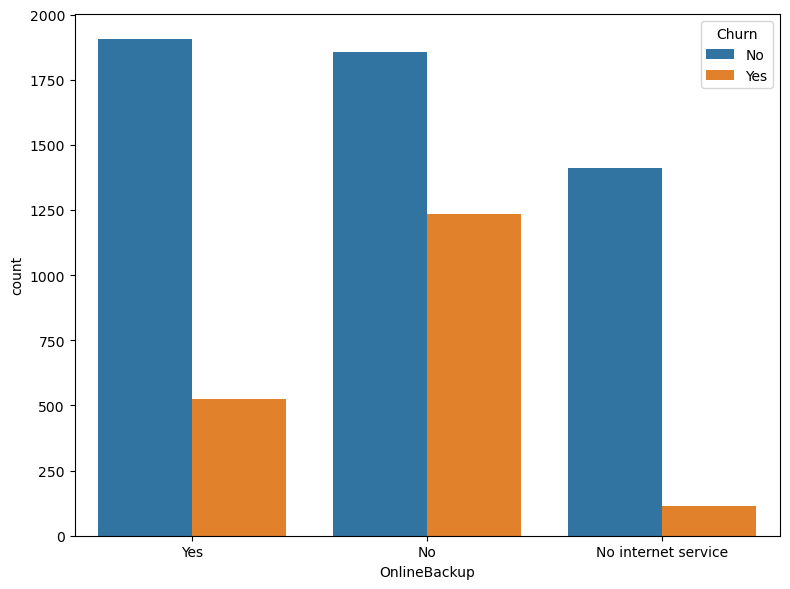

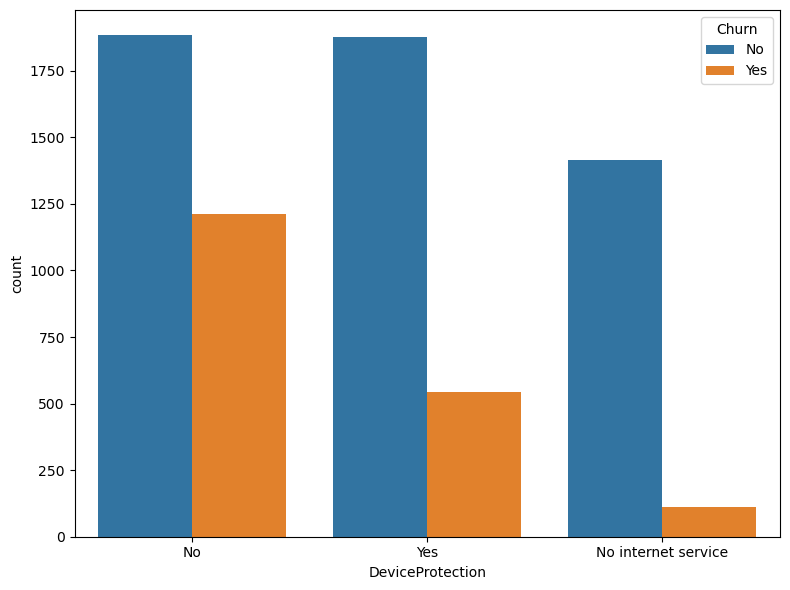

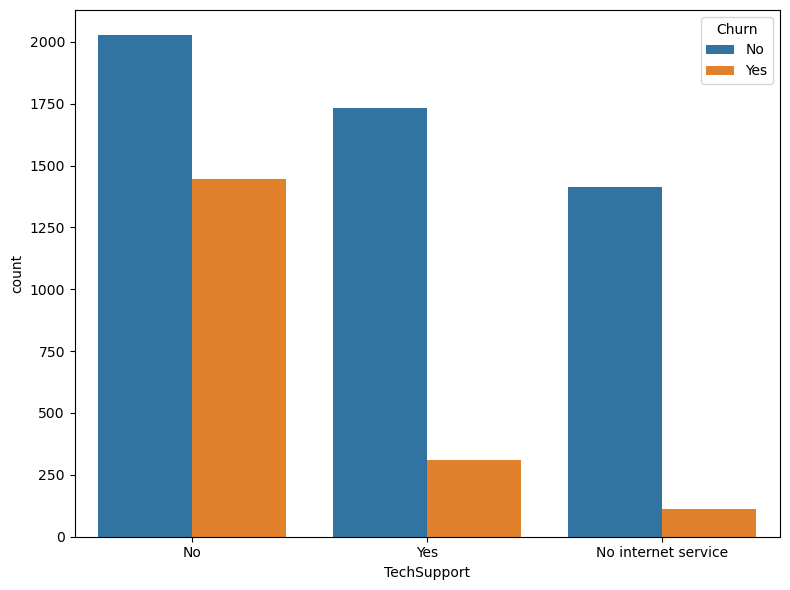

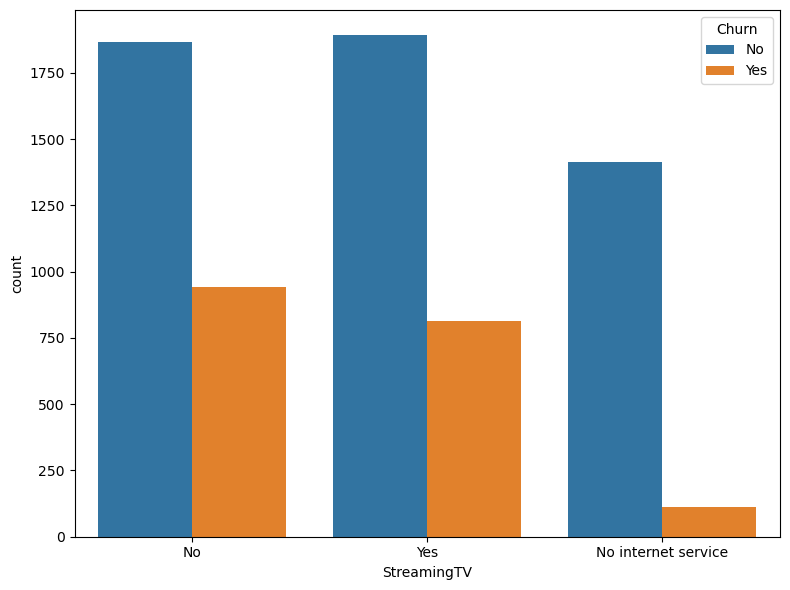

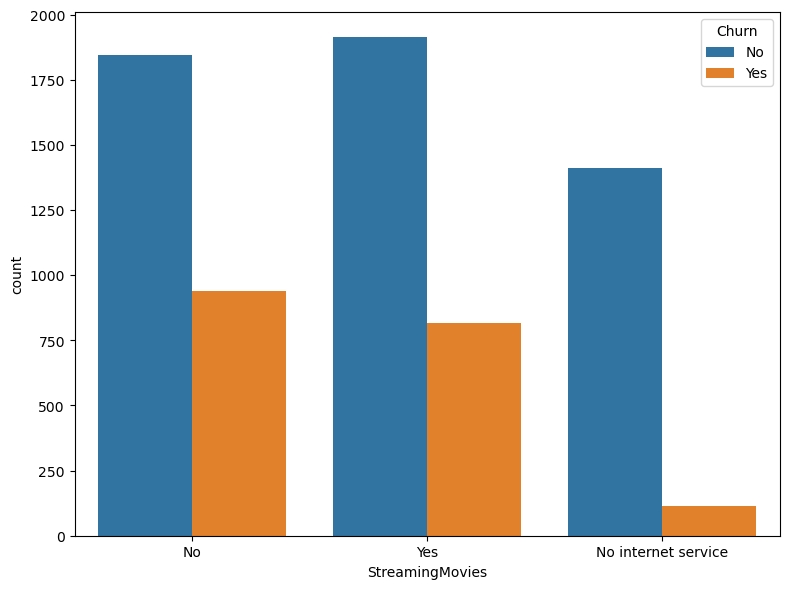

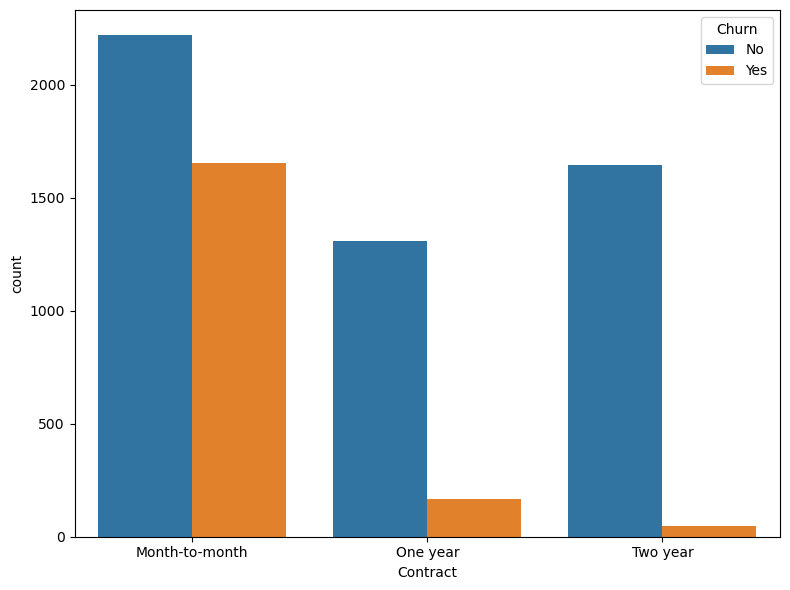

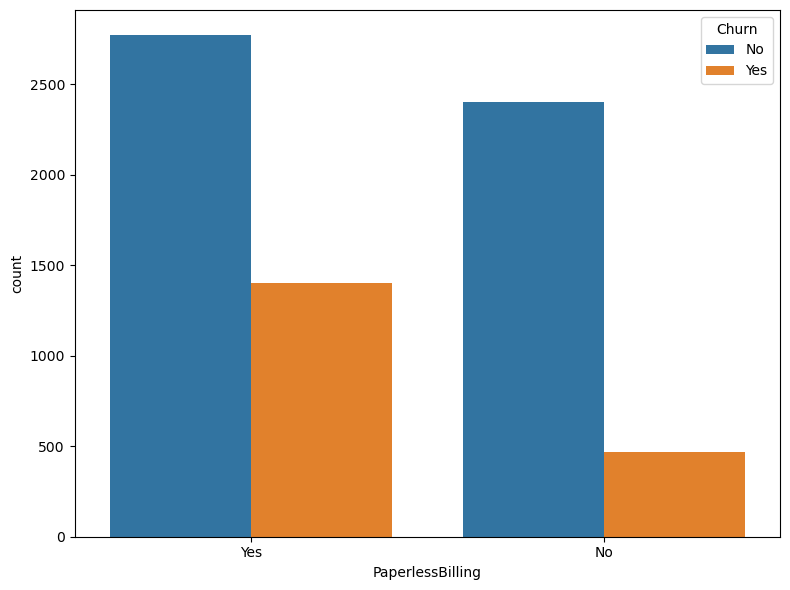

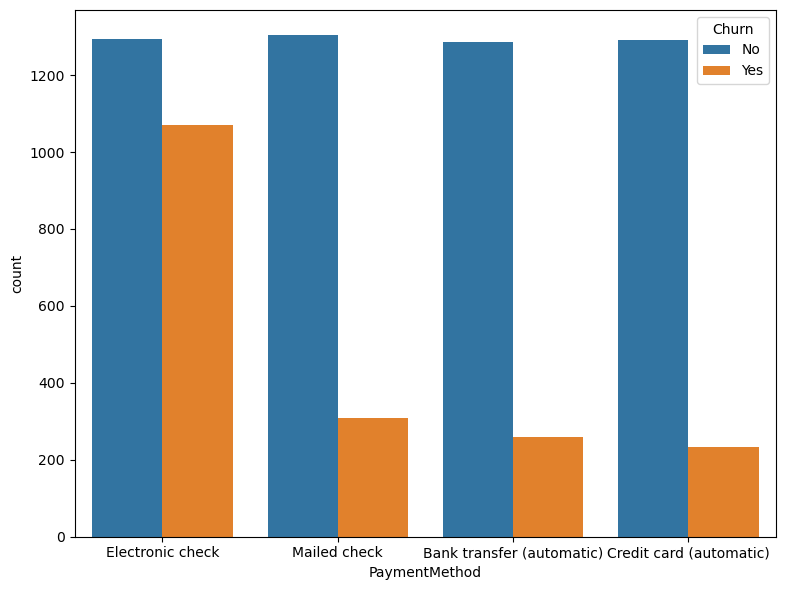

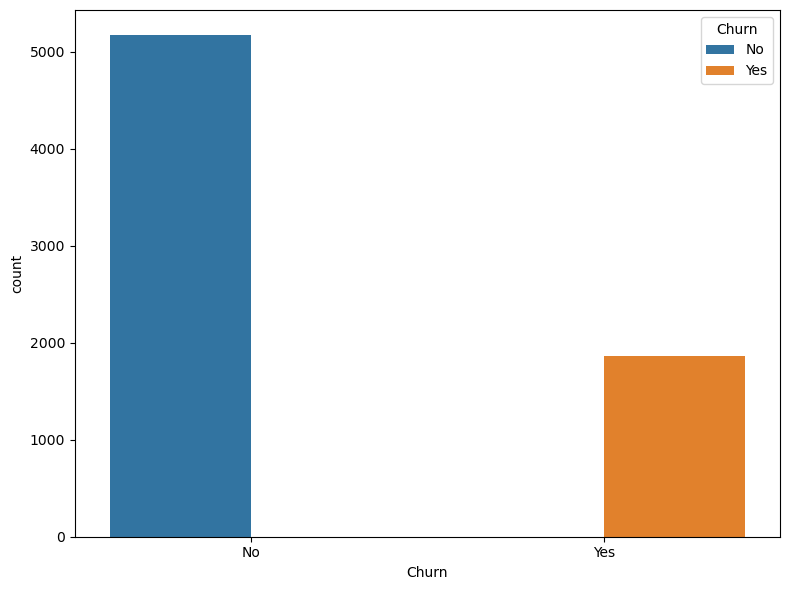

In [20]:
for vars in categorical_var_list:
    freqs.plot_count_fun(df,vars,'Churn')

### 04.5 Categorical vs Monthly Charges and Churn

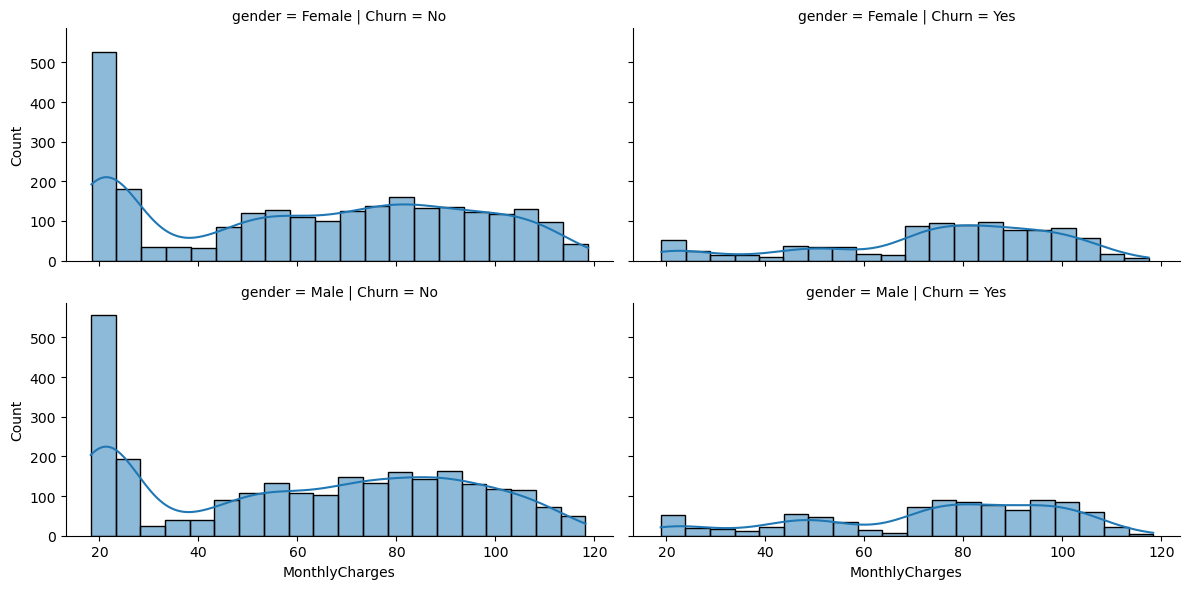

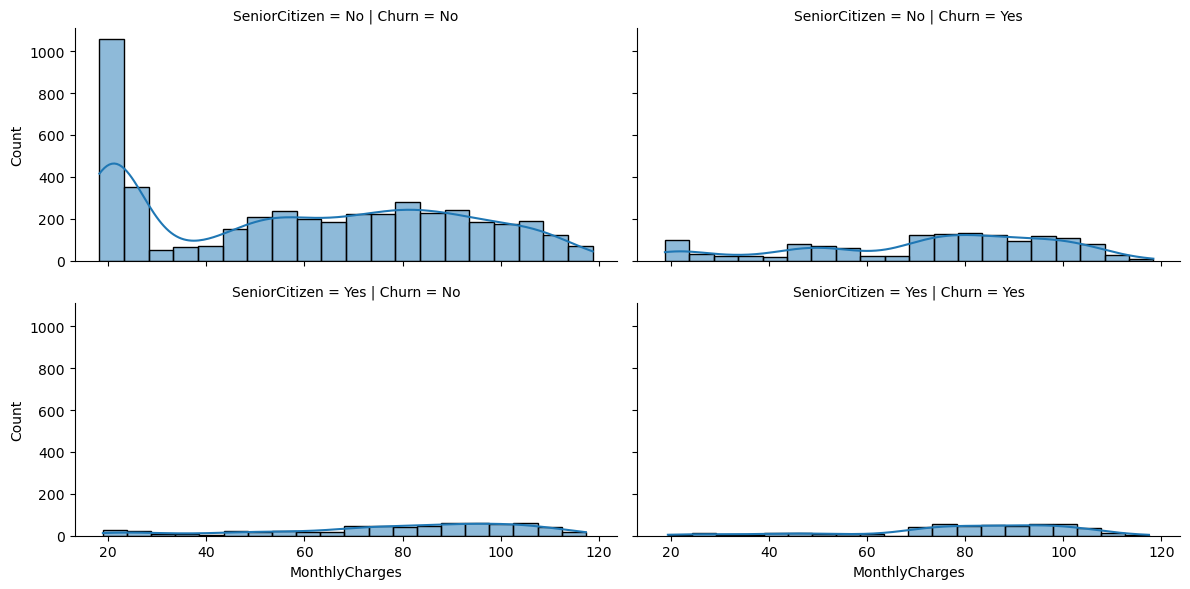

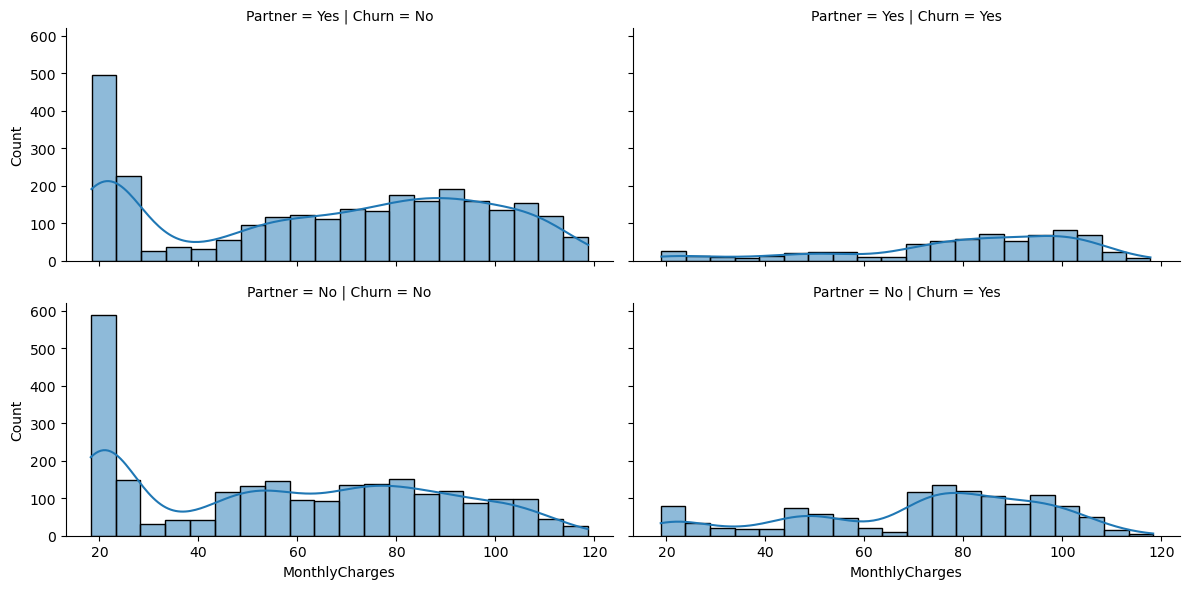

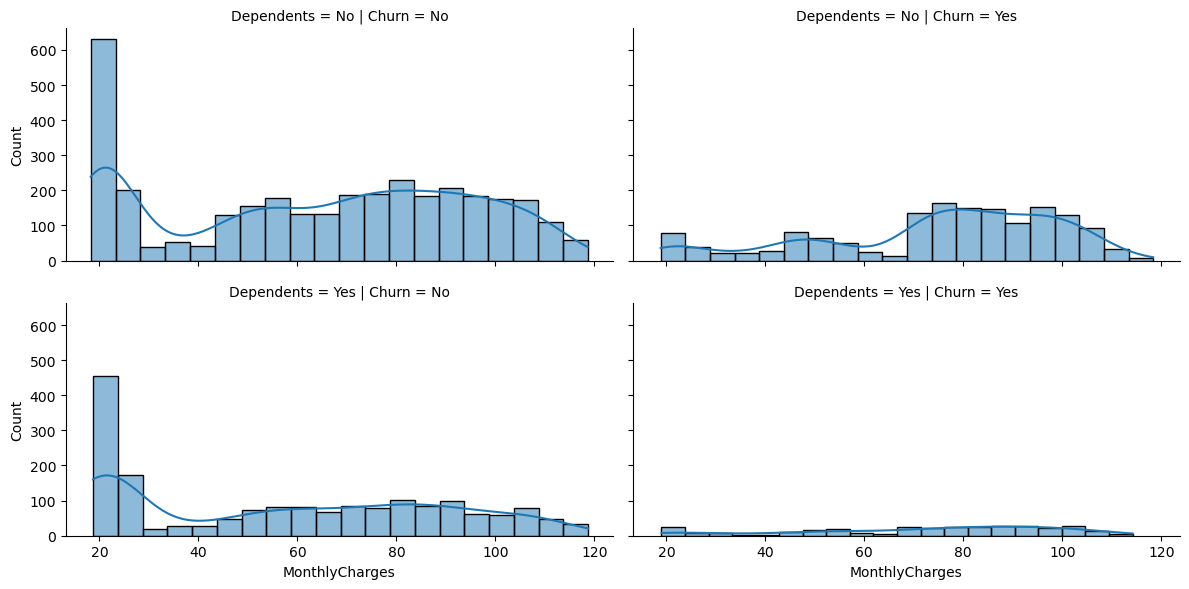

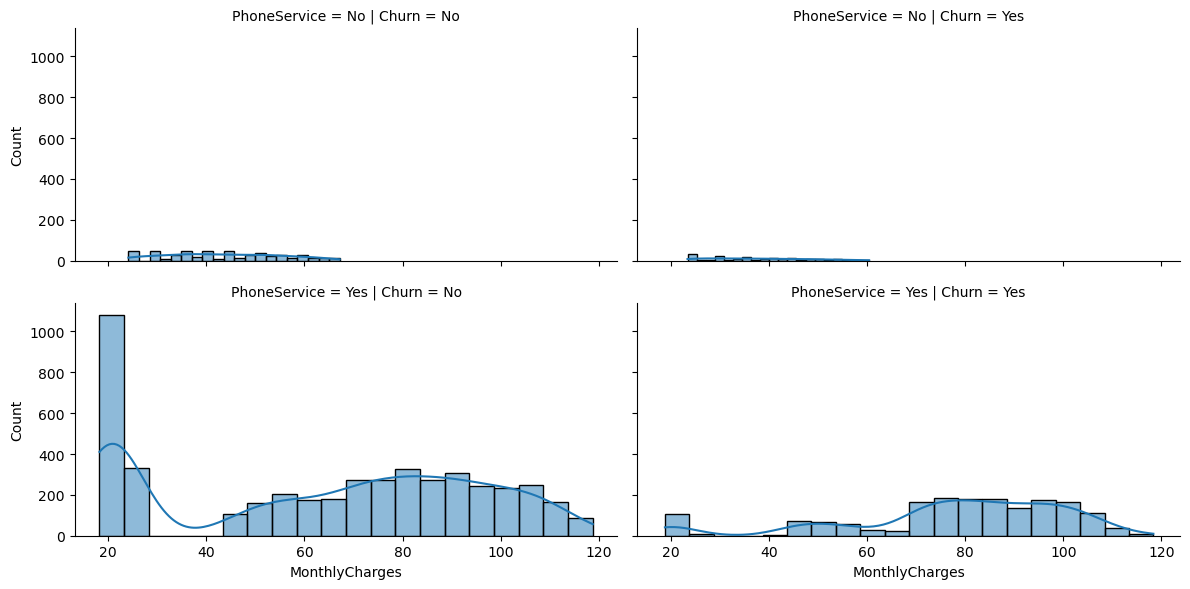

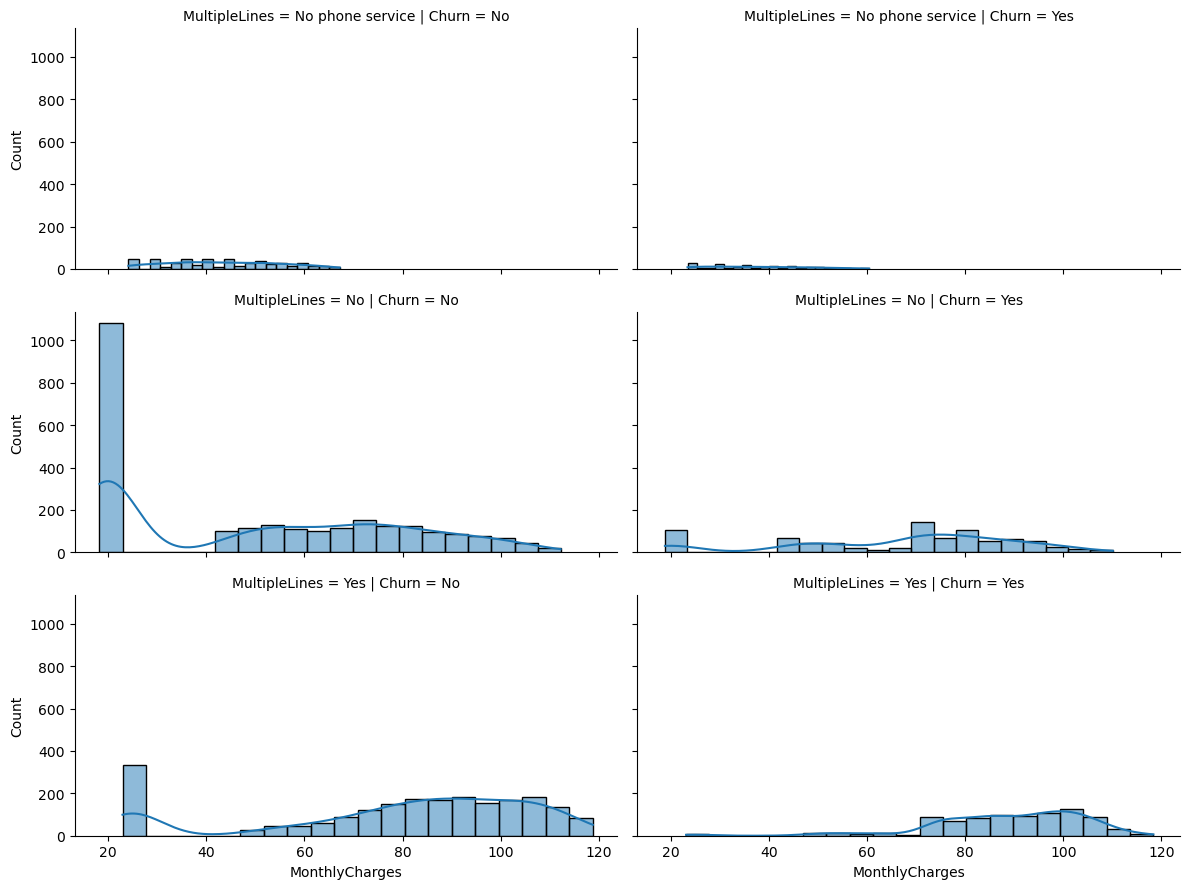

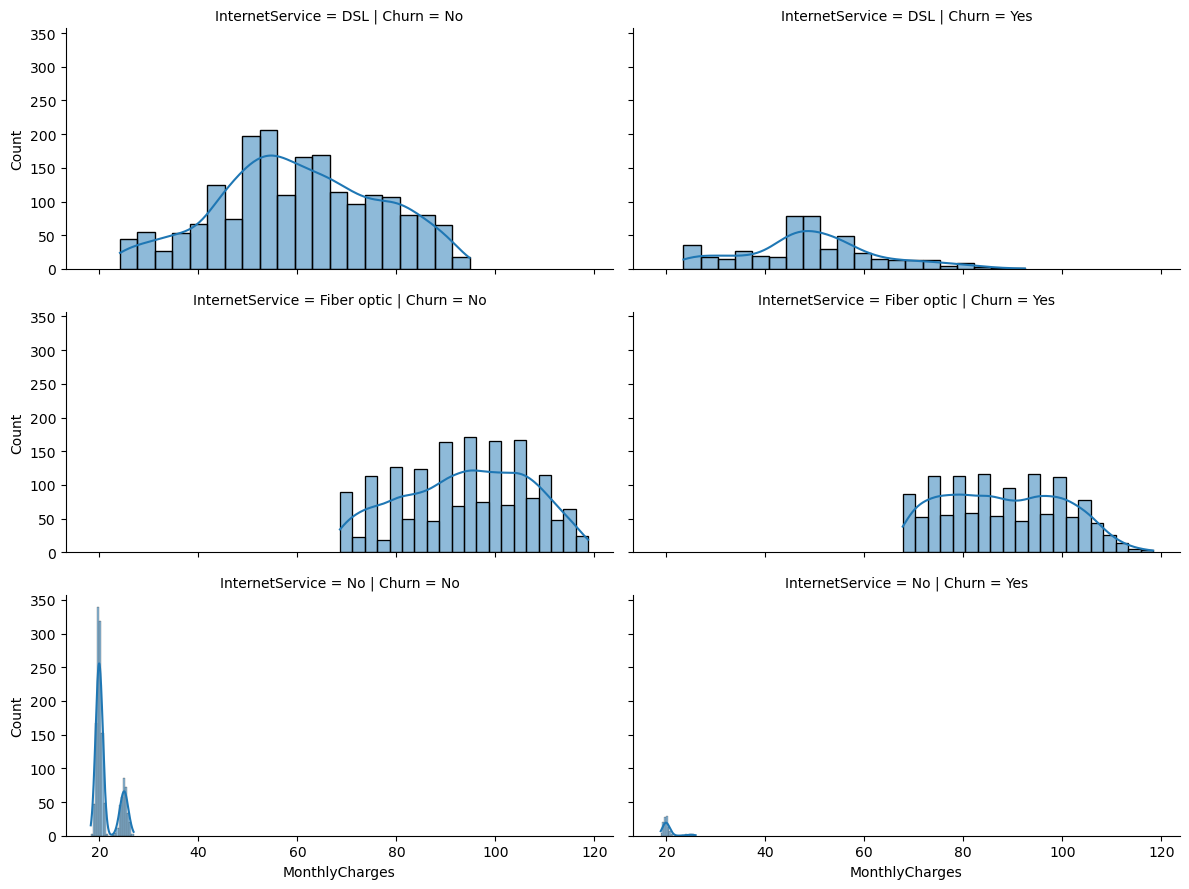

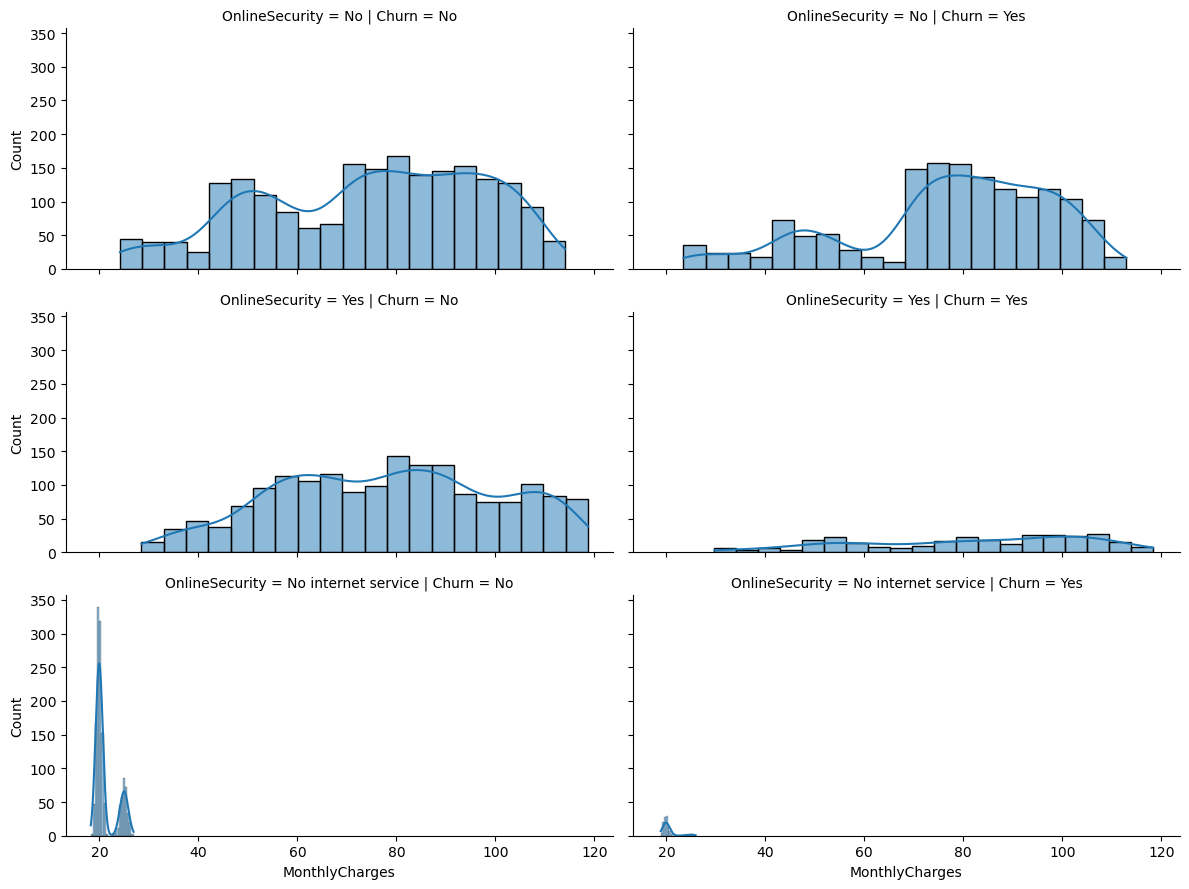

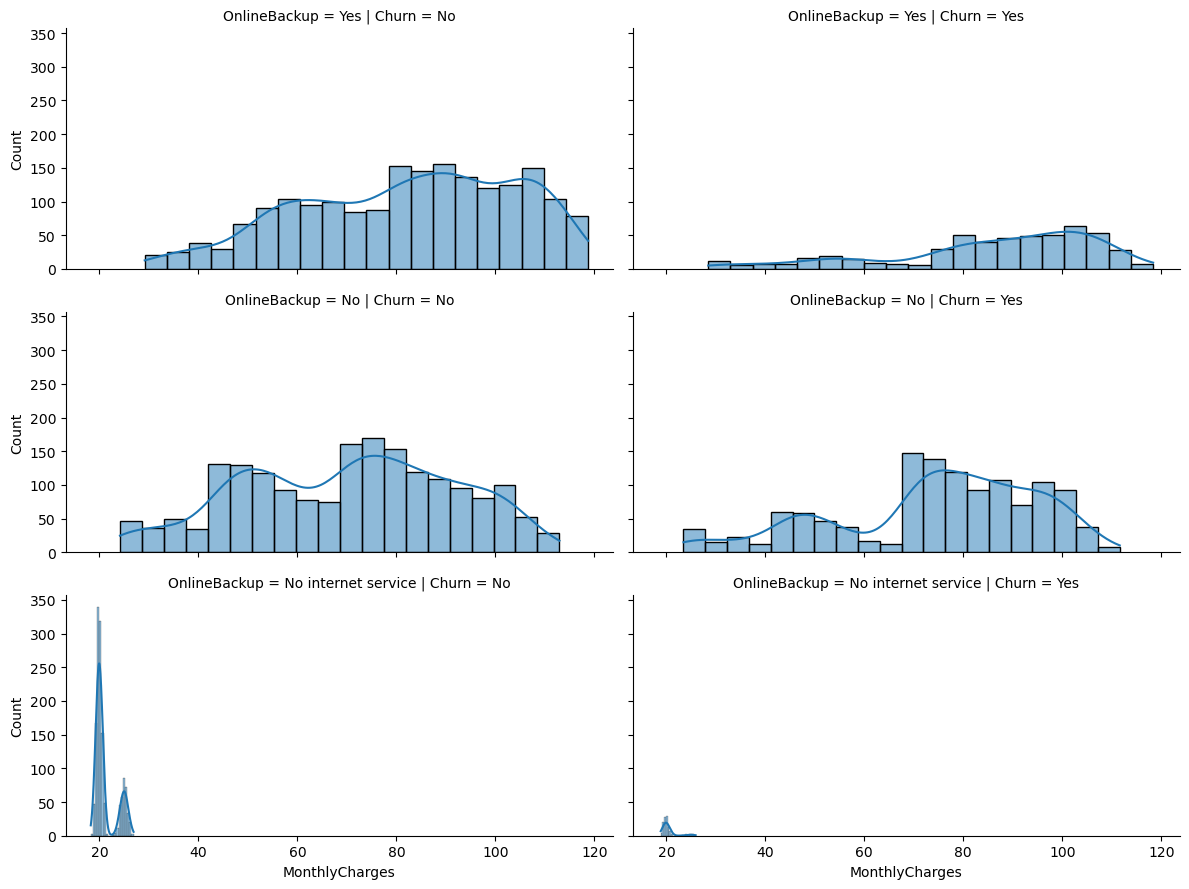

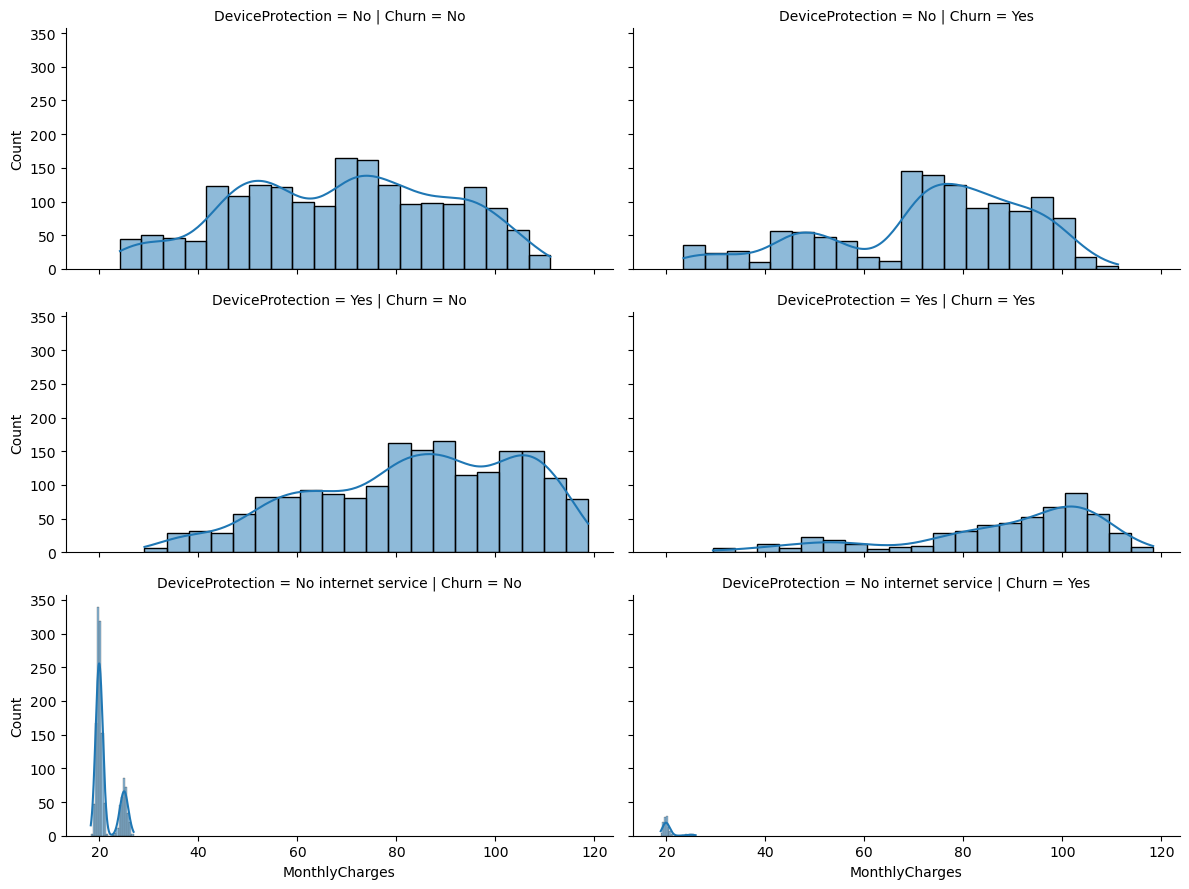

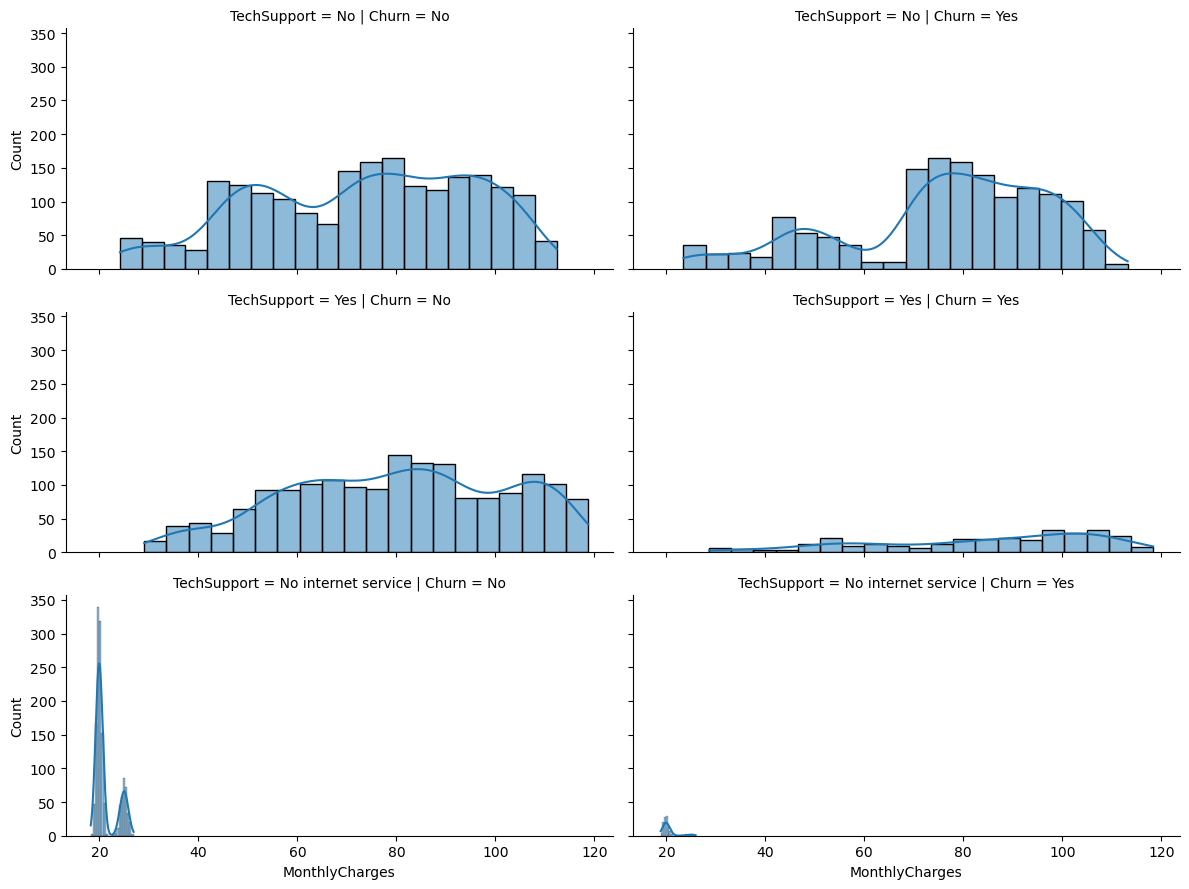

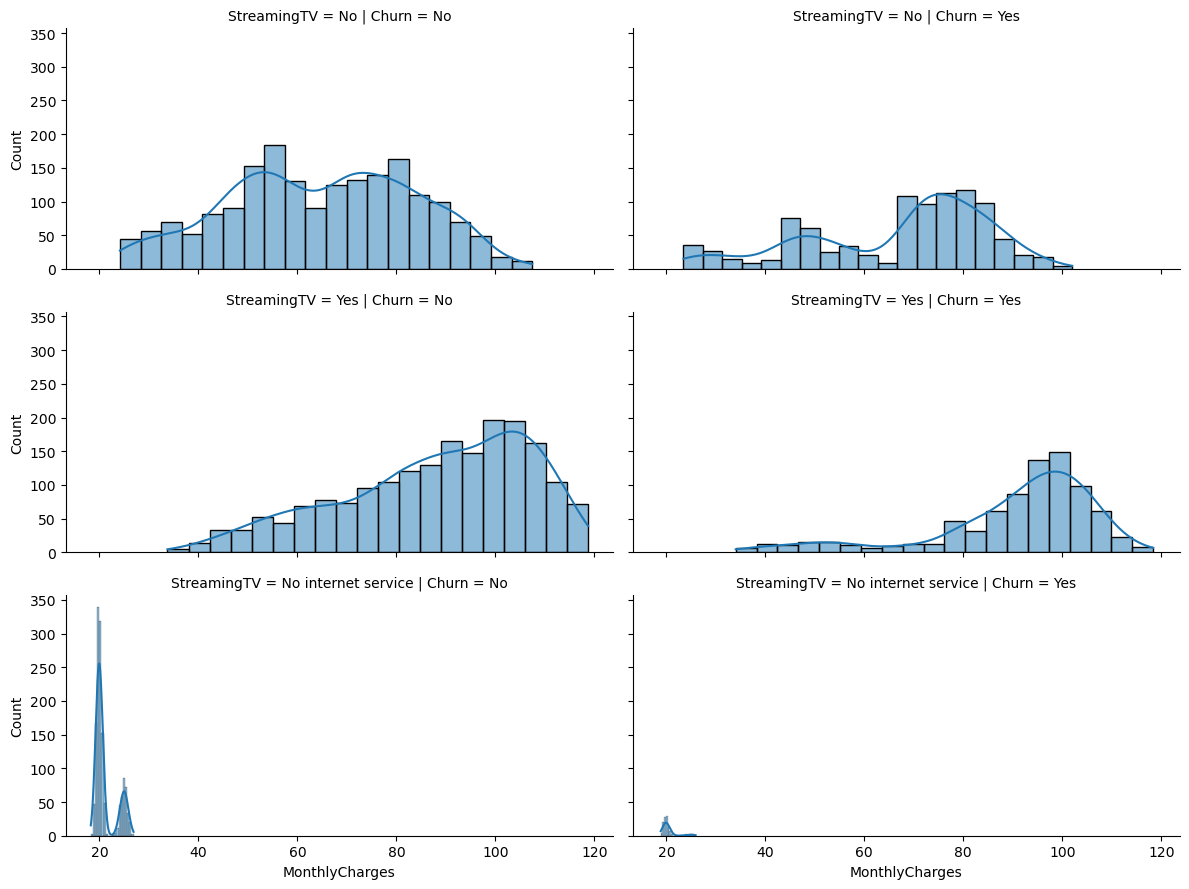

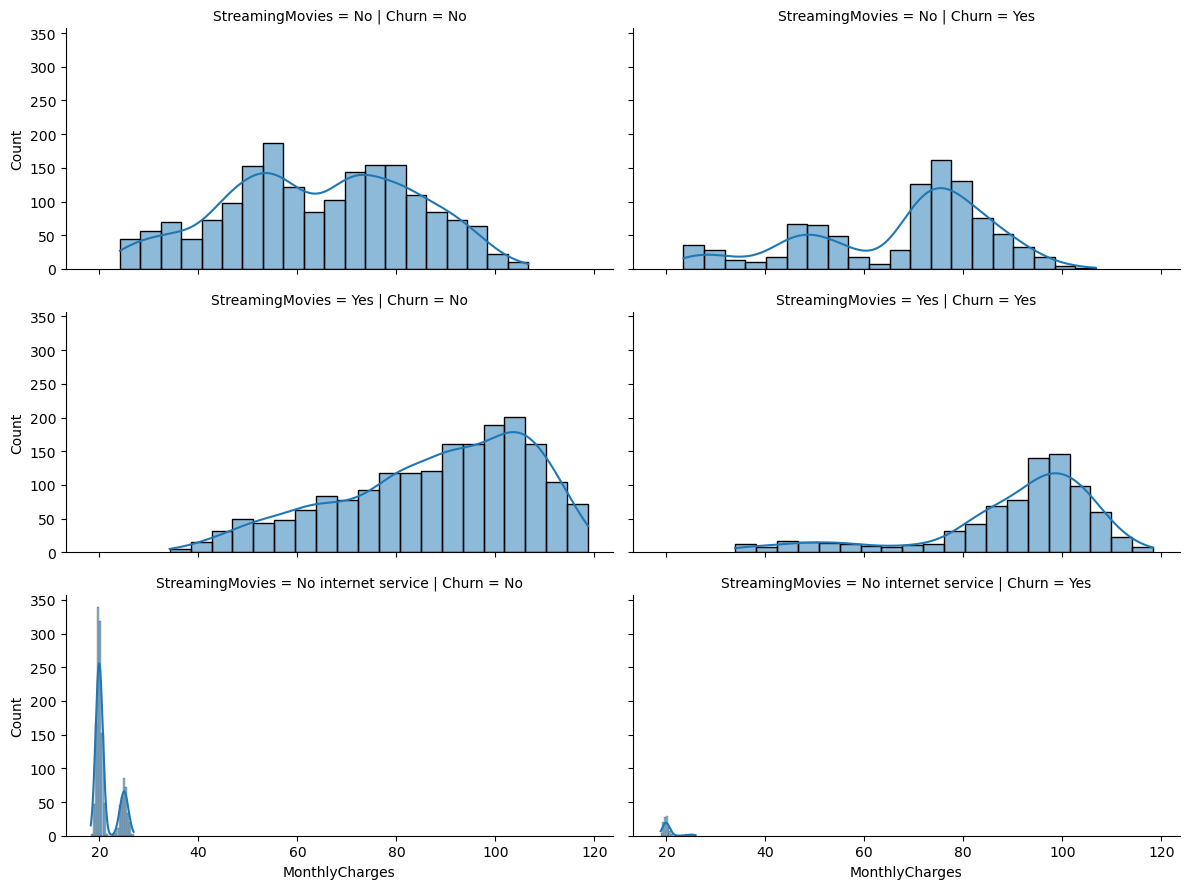

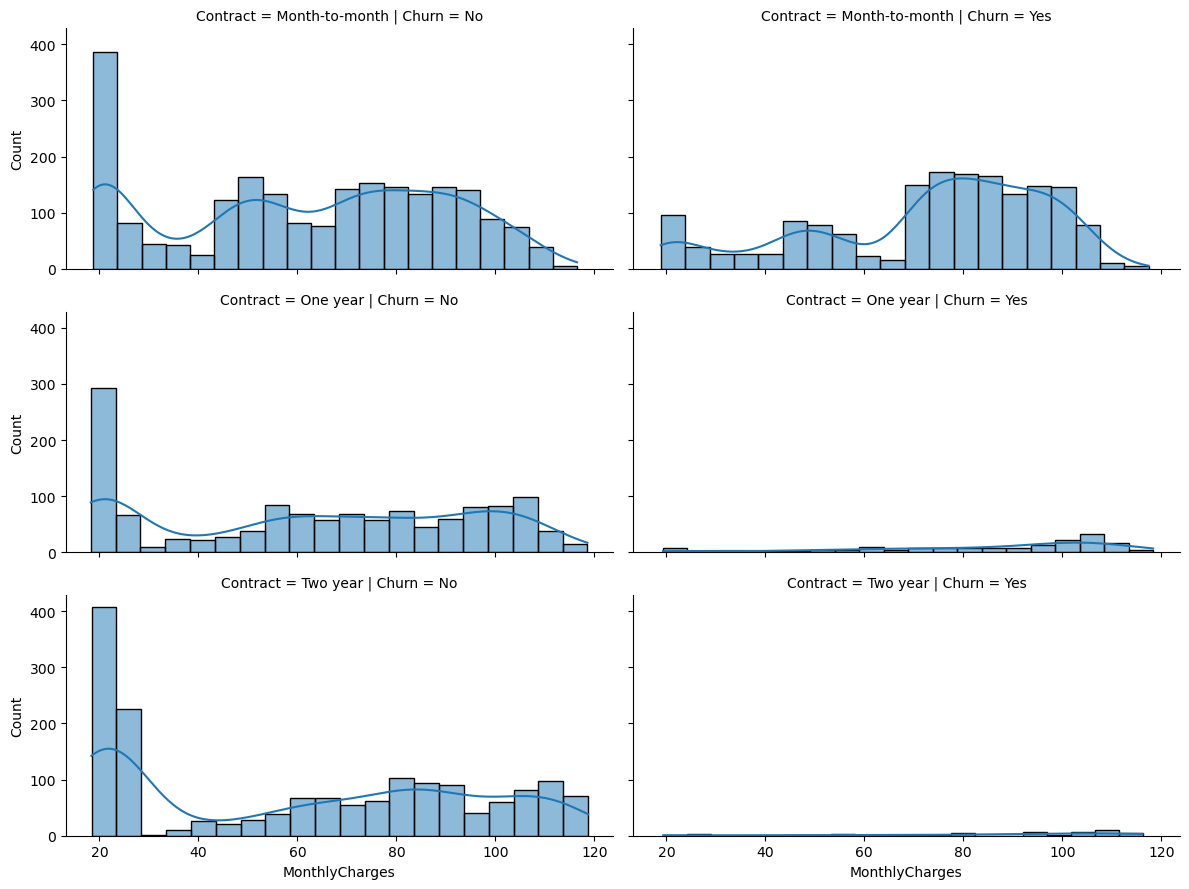

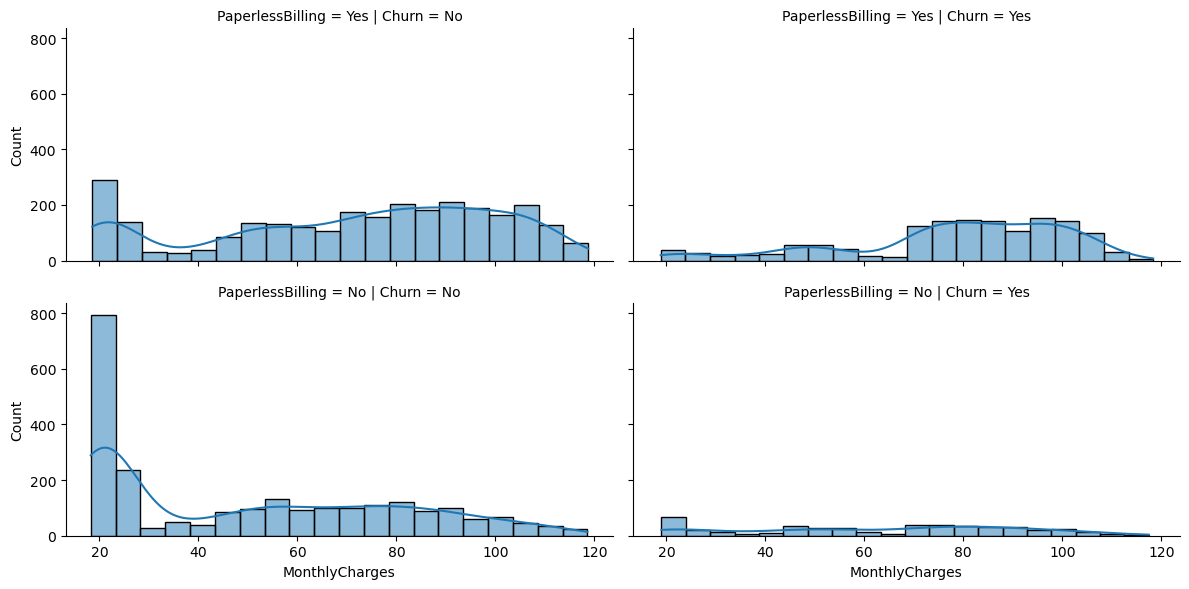

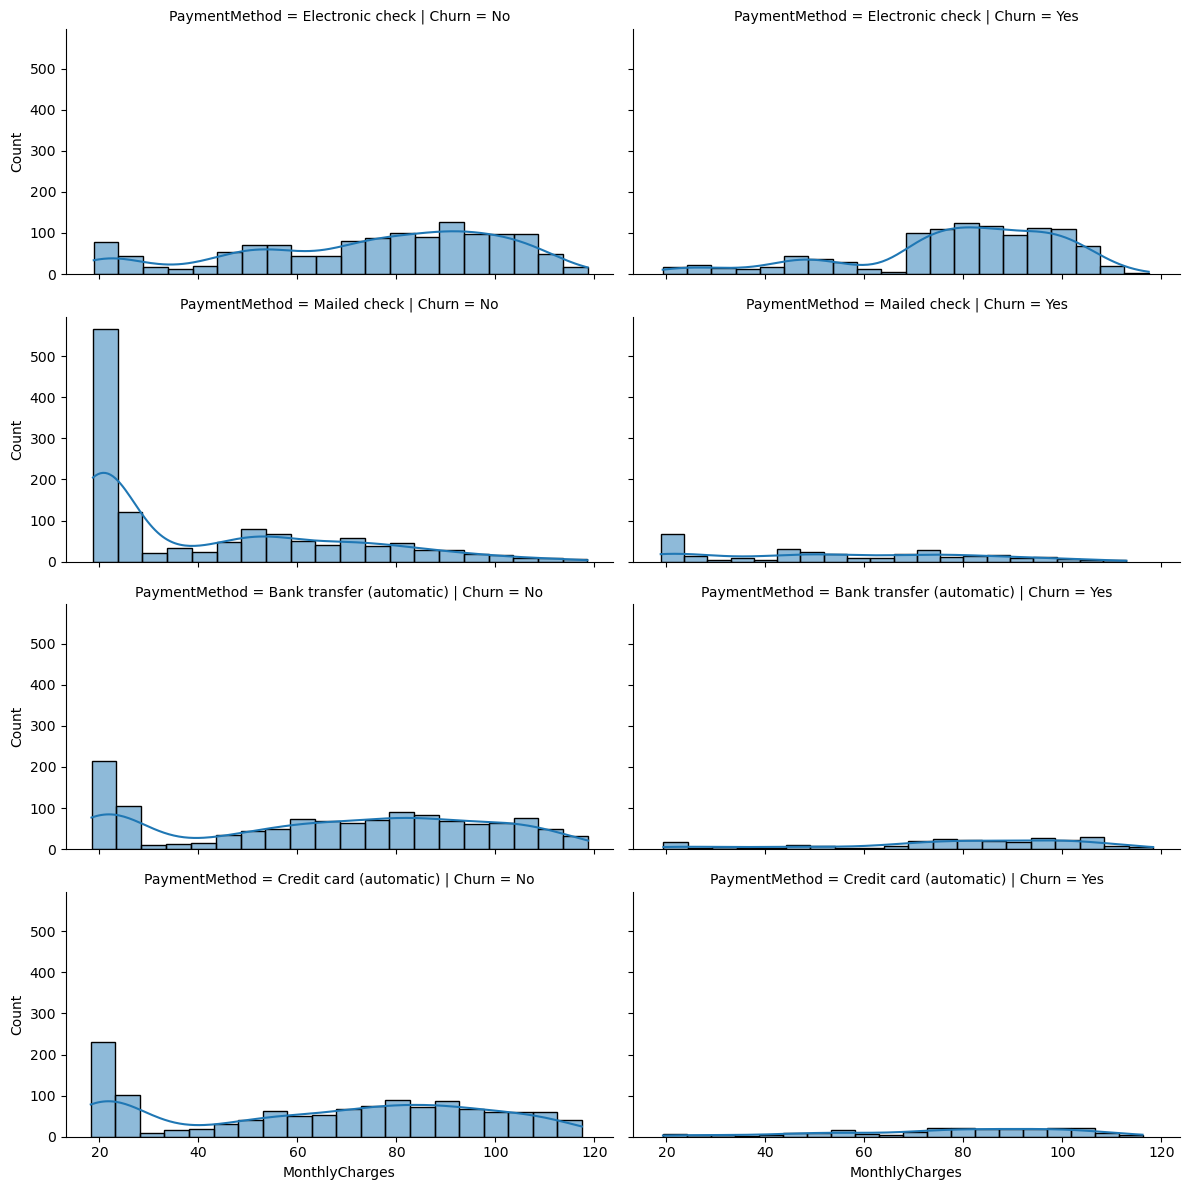

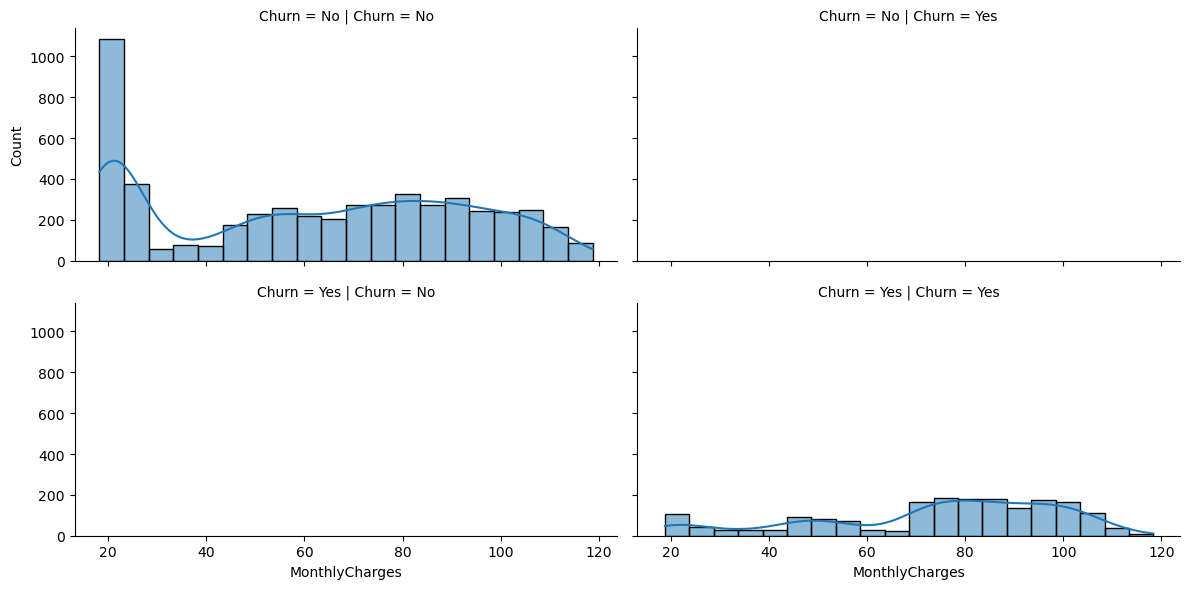

In [21]:
## Also, lets see what is the affect of the Monthly Charges
for vars in categorical_var_list:
    freqs.plot_density_fun(df,vars,'MonthlyCharges','Churn',20)

### 05 Export Cleaned Data

In [24]:
df.to_csv(f"{folder_paths.path}/data_cleaned.csv", index=True)